<div align="center" style="font-weight: bold; color:#fbb900">
    <div style="font-size: xx-large">Grado en Ingeniería Matemática e Inteligencia Artificial(iMAT)</div><br>
    <div style="font-size: x-large; color:gray">Tecnologia de Procesamiento de Big Data&ndash; SPARK</div><br>
    <div style="font-size: large; color:gray">María Jaque Oficialdegui, Emma Rey Sánchez y Catalina Royo-Villanova Seguí</div><br>
        <div style="font-size: large; color:gray">Escuela Técnica Superior de Ingeniería (ICAI)</div><br>
</div>

In [53]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import math
import pandas as pd
import subprocess
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates

from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DateType
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (StringIndexer,
                                OneHotEncoder,
                                PCA,
                                PolynomialExpansion,
                                Tokenizer,
                                HashingTF,
                                VectorAssembler,
                                StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.pipeline import Pipeline


from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import PolynomialExpansion, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.sql.functions import desc, row_number, dense_rank
from pyspark.sql.functions import lag, col

In [2]:
%%html
<style>
    .qst, .slides {background-color: #fbb900; padding:10px; border-radius: 5px; border: solid 2px #fbb900;}
    .qst:before, .slides:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color:  #fbb900;}
    .text_cell_render p, ul, ol {text-align: justify; text-justify: inter-word;}
    li {margin-bottom: 10px; margin-top: 10px;}
    div.output pre{border: 1px solid gray; border-radius: 1px; padding: 5px}
    td, th {font-size: 110%;}
</style>

In [3]:
user = 'abd02'
appName = user+'_cl1_<sparksql'
spark = SparkSession.builder.master("yarn") \
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
if not (("sc" in globals()) or ("sc" in locals())):
    sc = pyspark.SparkContext()

print(sc)

<SparkContext master=yarn appName=abd02_cl1_<sparksql>


In [5]:
sc

<SparkContext master=yarn appName=abd02_cl1_<sparksql>

## Procesado de los datos
Nuestra base de datos se llama "real_estate" y la tabla con los datos es "data". Antes de comenzar nos moveremos a esa base de datos y comprobaremos que efectivamente hay información en la tabla.

In [6]:
spark.catalog.setCurrentDatabase("real_estate")

In [7]:
spark.catalog.listTables()

[Table(name='c500_real_estate', catalog='spark_catalog', namespace=['real_estate'], description='Imported by sqoop on 2024/03/12 19:39:04', tableType='MANAGED', isTemporary=False),
 Table(name='data', catalog='spark_catalog', namespace=['real_estate'], description=None, tableType='MANAGED', isTemporary=False)]

In [8]:
# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
df = spark.table("data")

In [9]:
# Mostrar el DataFrame resultante
df.show(10)

+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|2020-01-02|142.98894185962598|143.42163110894384|139.97782189668848|141.04627990722656|1094900.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-03| 139.9601258223185|142.48558983037347| 139.9601258223185| 141.8498077392578| 371300.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-06|141.32002513294364|142.67989801099486|140.92266458118684|142.19422912597656| 604700.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-07| 138.1852552232042|139.10359973486672|136.60462528551435|137.54063415527344|4543900.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-08|138.19406930717

In [10]:
# Ordenamos los datos cronológicamente
data = df.orderBy(F.desc("date"))
# data.show(10)

+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|2024-04-24| 755.5900268554688|            768.25| 754.5349731445312| 756.8400268554688| 775565.0|      0.0|        0.0|  EQIX|0001101239|
|2024-04-24|126.37000274658203|128.84500122070312|125.98500061035156|128.39999389648438| 440861.0|      0.0|        0.0|   MAA|0000912595|
|2024-04-24|62.290000915527344| 65.20999908447266|  62.2406005859375| 64.61000061035156|3104464.0|      0.0|        0.0|   EQR|0000906107|
|2024-04-24| 118.1500015258789|119.82499694824219|116.88500213623047| 119.6500015258789| 829581.0|      0.0|        0.0|   ARE|0001035443|
|2024-04-24| 239.3699951171

In [11]:
# Preprocesamiento: limpieza y manejo de valores nulos
# Definir una ventana particionada por alguna columna si es necesario y ordenada por fecha
window = Window.orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Aplicar la operación de 'ffill' para cada columna que desees rellenar
for column in data.columns:
    data = data.withColumn(column, F.last(data[column], ignorenulls=True).over(window))

### Añadir el Lag
Para predecir el valor actual en base al valor del día anterior

In [12]:
windowSpec = Window.partitionBy("symbol").orderBy("date")

# Crear nuevas columnas para las características del día anterior
for feature in ["Open", "Close", "Low", "Volume", "High"]:
    data = data.withColumn(f"{feature}_prev_day", F.lag(data[feature]).over(windowSpec))

# Filtrar cualquier fila que tenga valores nulos resultantes de la función lag()
data = data.filter(
    (col("Open_prev_day").isNotNull()) &
    (col("Close_prev_day").isNotNull()) &
    (col("Low_prev_day").isNotNull()) &
    (col("Volume_prev_day").isNotNull()) &
    (col("High_prev_day").isNotNull())
)

### Dividir en train y test

In [13]:
# Crear características de series temporales como el precio de cierre retrasado

# Definir una especificación de ventana particionada por empresa y ordenada por fecha en orden descendente
windowSpec = Window.partitionBy("Symbol").orderBy(F.col("Date").desc())

# Agregar una columna de número de fila dentro de cada partición
data = data.withColumn("row_number", row_number().over(windowSpec))

# Filtrar para obtener solo los últimos 7 registros para cada empresa
test_df = data.filter(col("row_number") <= 7).drop("row_number").orderBy(F.col("Date").asc())

# Para el conjunto de entrenamiento, excluimos los registros seleccionados para el test
train_df = data.filter(col("row_number") > 7).drop("row_number").orderBy(F.col("Date").asc())

# test_df.show(10)
# train_df.show(10)

+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|     Open_prev_day|    Close_prev_day|      Low_prev_day|Volume_prev_day|     High_prev_day|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+
|2024-04-16| 95.95999908447266| 96.12999725341797|             94.75| 95.05000305175781| 606700.0|      0.0|        0.0|   CPT|0000906345|  98.5199966430664| 96.62000274658203| 95.97000122070312|       540800.0|  98.7699966430664|
|2024-04-16|33.400001525878906|33.415000915527344|              33.0|33.0400

+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|     Open_prev_day|    Close_prev_day|      Low_prev_day|Volume_prev_day|     High_prev_day|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+
|2018-01-03| 75.30405983996548| 75.76513670509456|  74.9994161788188| 75.48519897460938| 414600.0|      0.0|        0.0|   CPT|0000906345| 75.72397592045682| 75.33699798583984|  74.9582553617917|       385800.0| 75.82277452047721|
|2018-01-03|20.426168828162695|20.547494717251553| 20.23551362346002|20.3481

### Columnas
Nos quedamos solo con las columnas necesarias para predecir

In [14]:
# Definir el VectorAssembler para transformar las características
features = ['Open', 'Low', 'Close', 'Volume']  # Columnas que serán usadas como características
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler = VectorAssembler(inputCols=[f'{feature}_prev_day' for feature in features], outputCol="features")

## Modelo Linear Regression

Obtenemos los datos de la empresa "MAA" para realizar la predicción

In [60]:
# Obtenemos los datos de train y test de la empresa 
train_data_lr = train_df.filter(data.Symbol == 'MAA')
test_data_lr = test_df.filter(data.Symbol == 'MAA')

# train_data_lr.show()
# test_data_lr.show()

### Modelo

In [17]:
# Modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="Close")

Se crea un pipeline que primero crea el assembler para unificar las columnas usadas para predicción en la variable "features" y posteriormente emplea cross validation para encontrar los mejores parámetros para predecir el valor

In [18]:
pipeline = Pipeline(stages=[assembler, lr])

# Configurar el CrossValidator con Grid de Parámetros
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Usar 3 pliegues para la validación cruzada

# Entrenar el modelo utilizando solo el conjunto de entrenamiento
cvModel = crossval.fit(train_data_lr)

# Evaluar el modelo en el conjunto de prueba
test_predictions_lr = cvModel.transform(test_data_lr)

### Parámetros

In [19]:
bestLRModel = cvModel.bestModel.stages[-1]  # The last stage in the pipeline is the GLR model

# Print the parameters of the best model
print("Best model parameters:")
paramMap = bestLRModel.extractParamMap()
for param, value in paramMap.items():
    print(f"{param.name}: {value}")

Best model parameters:
aggregationDepth: 2
elasticNetParam: 0.75
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: Close
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.0001
solver: auto
standardization: True
tol: 1e-06


### Métricas

In [20]:
rmse = evaluator.evaluate(test_predictions_lr)
r2 = evaluator.evaluate(test_predictions_lr, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(test_predictions_lr, {evaluator.metricName: "mae"})

print("RMSE: ", rmse)
print("MAE", mae)
print("r2: ", r2)

# Guardar el mejor modelo
cvModel.bestModel.write().overwrite().save("./model_lr")

RMSE:  1.3013136214605103
MAE 1.0226897322200503
r2:  0.35279270180496136


Se almacenan los resultados en un único dataset para poder consultarlos en otro momento

In [41]:
# Primero, me aseguro de que tanto los datos de prueba como las predicciones tienen una columna 'Date' para unirlos
test_data_lr = test_data_lr.withColumn('Date', F.to_date(F.col('Date')))
test_predictions_lr = test_predictions_lr.withColumn('Date', F.to_date(F.col('Date')))
test_predictions_lr = test_predictions_lr.select('Date', 'prediction')
# Unir las predicciones del modelo con el DataFrame de prueba basado en la fecha
# Suponiend.selecto que test_predictions_lr ya tiene una columna 'Date' que se puede utilizar para la unión
test_pd_lr = test_data_lr.join(test_predictions_lr, ['Date'], 'left_outer')

test_pd_lr.show()
# Para el conjunto de entrenamiento, puedes crear una columna 'prediction' que contenga nulos
# ya que no hay predicciones para los datos de entrenamiento
train_pd_lr = train_data_lr.withColumn('prediction', F.lit(None))

# Unir los conjuntos de datos de entrenamiento y prueba
concatenated_data = train_pd_lr.union(test_pd_lr)

# Ordenar por fecha
concatenated_data = concatenated_data.orderBy(F.col('Date').desc())

# Mostrar los datos
# concatenated_data.show()


+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|     Open_prev_day|    Close_prev_day|      Low_prev_day|Volume_prev_day|     High_prev_day|        prediction|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+------------------+
|2024-04-24|126.37000274658203|128.84500122070312|125.98500061035156|128.39999389648438| 440861.0|      0.0|        0.0|   MAA|0000912595|127.44000244140625|127.48999786376953|127.16999816894531|       708000.0|            128.75| 127.8446796442902|


+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|     Open_prev_day|    Close_prev_day|      Low_prev_day|Volume_prev_day|     High_prev_day|        prediction|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+------------------+------------------+------------------+---------------+------------------+------------------+
|2024-04-24|126.37000274658203|128.84500122070312|125.98500061035156|128.39999389648438| 440861.0|      0.0|        0.0|   MAA|0000912595|127.44000244140625|127.48999786376953|127.16999816894531|       708000.0|            128.75| 127.8446796442902|


### Gráfica de los resultados

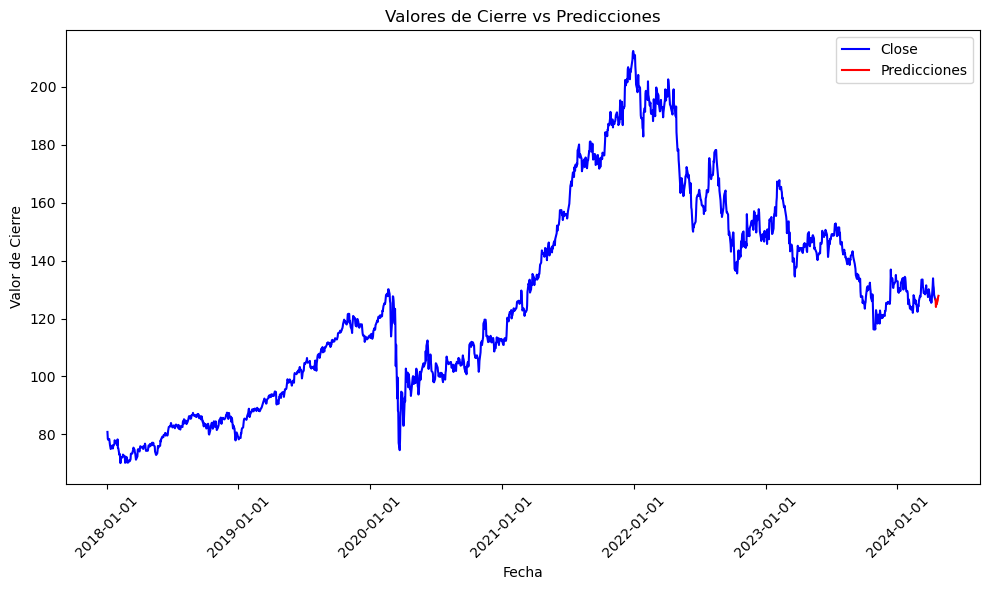

In [56]:
# Convertir la columna de fechas a timestamp sin zona horaria
train_pd_lr = train_pd_lr.withColumn('Date', F.to_timestamp('Date', 'yyyy-MM-dd'))
test_pd_lr = test_pd_lr.withColumn('Date', F.to_timestamp('Date', 'yyyy-MM-dd'))

# Recolectar los datos para la visualización
train_dates = [row['Date'] for row in train_pd_lr.collect()]
train_closes = [row['Close'] for row in train_pd_lr.collect()]
test_dates = [row['Date'] for row in test_pd_lr.collect()]
test_predictions = [row['prediction'] for row in test_pd_lr.collect()]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Configurar el formato del eje x para fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Graficar los valores de 'Close' del conjunto de entrenamiento
plt.plot(train_dates, train_closes, label='Close', color='blue')

# Graficar las predicciones del conjunto de prueba
plt.plot(test_dates, test_predictions, label='Predicciones', color='red')

# Configurar el título y etiquetas de los ejes
plt.title('Valores de Cierre vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

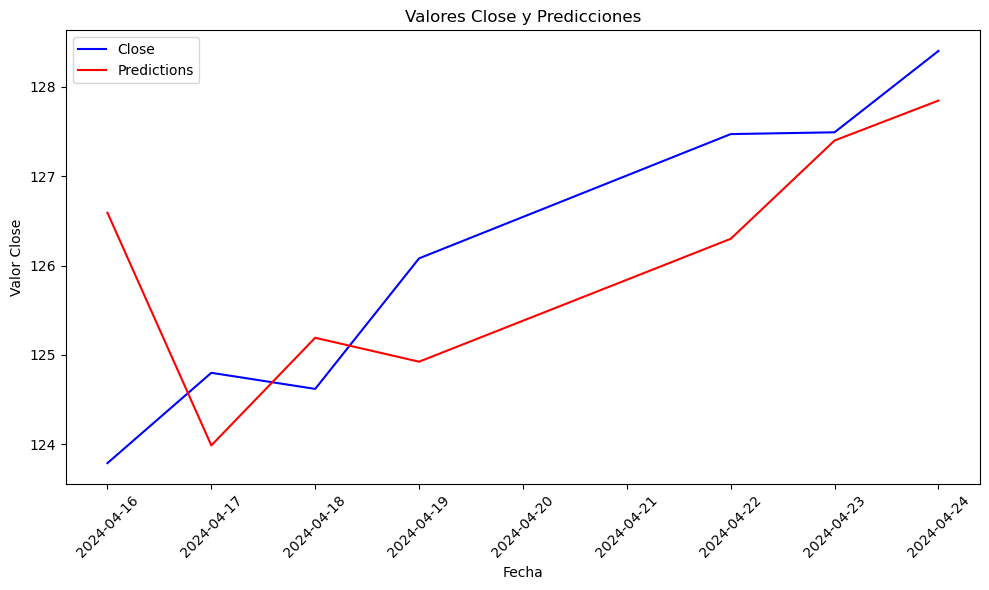

In [59]:
# Asegurarnos de que las fechas están en formato correcto (suponiendo que el formato es 'yyyy-MM-dd')
test_pd_lr = test_pd_lr.withColumn('Date', F.to_timestamp('Date', 'yyyy-MM-dd'))

# Ordenamos los datos por fecha
test_pd_lr = test_pd_lr.orderBy('Date')

# Recolectamos los datos para la visualización
test_dates = [row['Date'] for row in test_pd_lr.collect()]
test_highs = [row['Close'] for row in test_pd_lr.collect()]
test_predictions = [row['prediction'] for row in test_pd_lr.collect()]

# Definir el tamaño de la figura
plt.figure(figsize=(10, 6))

# Configurar el formato del eje x para fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Trama de los valores de cierre reales en el conjunto de prueba
plt.plot(test_dates, test_highs, label='Close', color='blue')

# Trama de las predicciones del modelo en el conjunto de prueba
plt.plot(test_dates, test_predictions, label='Predictions', color='red')

# Etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor Close')
plt.title('Valores Close y Predicciones')

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

plt.legend()

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()